In [16]:
import importlib
import model.Portfolio as Portfolio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# importlib.reload(Portfolio)

In [7]:
names = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD"]
p = Portfolio.Portfolio()

# Add all assets
for name in names:
    p.addAsset(f"data/{name}.csv", name)

# Convert non SGD assets to SGD
p.addExchangeRate("data/forex/SGDEUR.csv", "EUR", True)
p.addExchangeRate("data/forex/USDSGD.csv", "USD", False)
p.exchangeAdjustment(0, "EUR")
p.exchangeAdjustment(3, "USD")
p.exchangeAdjustment(4, "USD")
p.exchangeAdjustment(5, "USD")
p.exchangeAdjustment(8, "USD")

In [8]:
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578,
]

p.portfolioPerformance(currentWeight)

{'returns': 0.046602380697228225,
 'variance': 0.004724437320510276,
 'sharpe': 9.864112387503281}

In [9]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)
    return w

In [11]:
%%time

noSimulations = 10000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(len(names))
    perf = p.portfolioPerformance(weights)

    simWeights.append(weights)
    simRets.append(perf["returns"])
    simVols.append(perf["variance"])
    simSharpes.append(perf["sharpe"])

CPU times: user 38.4 s, sys: 3.61 ms, total: 38.4 s
Wall time: 38.4 s


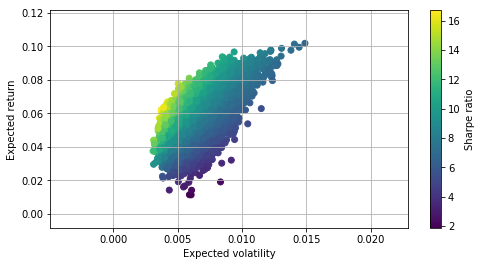

In [14]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [18]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []
for x in sortedIndices:
    results.append(np.insert(simWeights[x], 0, [simSharpes[x], simRets[x], simVols[x]]))
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + names)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD
0,15.437993,0.077766,0.005037,0.147190,0.085154,0.013996,0.164329,0.357804,0.025233,0.070123,0.049841,0.086329
1,15.457491,0.065314,0.004225,0.041980,0.220620,0.033602,0.198651,0.235858,0.081527,0.040417,0.128051,0.019295
2,15.464263,0.056468,0.003652,0.057585,0.237407,0.023876,0.056257,0.211709,0.143324,0.031877,0.227869,0.010094
3,15.668039,0.060689,0.003873,0.078326,0.236904,0.026261,0.077076,0.251619,0.100825,0.135512,0.032671,0.060805
4,15.860658,0.066790,0.004211,0.150963,0.089571,0.009140,0.085817,0.318670,0.000689,0.044174,0.209327,0.091648
5,15.863146,0.065277,0.004115,0.104585,0.226275,0.017742,0.188342,0.231636,0.005537,0.029935,0.148449,0.047499
6,15.927438,0.057137,0.003587,0.082970,0.248626,0.026596,0.126703,0.228865,0.019971,0.090871,0.124210,0.051188
7,16.259337,0.060693,0.003733,0.075923,0.248183,0.027092,0.074676,0.282549,0.026242,0.048944,0.061133,0.155258
8,16.269393,0.063633,0.003911,0.009195,0.286576,0.012487,0.174300,0.257531,0.080071,0.013934,0.122042,0.043864
9,16.716811,0.062122,0.003716,0.020903,0.270580,0.001495,0.003614,0.282653,0.247418,0.128673,0.031352,0.013311


In [19]:
import scipy.optimize as sco
import numpy as np

# Caution: Do not use this optimiser yet... it over optimises...
class Optimizer:
    def __init__(self, portfolio):
        self.portfolio = portfolio

    def optimize(self):
        numberOfAssets = len(self.portfolio.assetNames)
        constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        bounds = tuple((0, 1) for x in range(numberOfAssets))
        initial = np.array(numberOfAssets * [1.0 / numberOfAssets])
        options = sco.minimize(
            lambda x: -self.portfolio.portfolioPerformance(x, rf=0.02)["sharpe"],
            initial,
            method="SLSQP",
            bounds=bounds,
            constraints=constraints,
        )
        print(options)
        return options["x"]

In [38]:
%%time
o = Optimizer(p)
optimiserWeight = o.optimize()

     fun: -15.608382157192073
     jac: array([ 8.81454551,  8.8084259 , 29.84082437,  9.70446348,  8.81177592,
        8.8170352 ,  8.81780028,  8.81234694, 17.69694054])
 message: 'Optimization terminated successfully.'
    nfev: 163
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.17736687, 0.16119345, 0.        , 0.        , 0.51353228,
       0.05219099, 0.01816625, 0.07755016, 0.        ])
CPU times: user 506 ms, sys: 0 ns, total: 506 ms
Wall time: 505 ms


In [37]:
p.portfolioPerformance(optimiserWeight)

{'returns': 0.06593249084552458,
 'variance': 0.0029428092151344253,
 'sharpe': 22.40460934621371}

## Next Step

- Timeseries K-fold validation when generating weights
    - Monte carlo on K-1 segments of data
    - Test result on 1 segment of data
- Genetics algorithm
- Add backtest capabilities
    - Report over the entire period
    - Custom period

## Even More Advanced Shits

- Selective optimisation for time period (ie interest rate hike, financial crisis, etc)